In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [355]:
general = pd.read_csv('general_success.csv')
organizer = pd.read_csv('organizer_dollar.csv')
comments = pd.read_csv('comments_dollar.csv')
updates = pd.read_csv('updates_dollar.csv')
donations = pd.read_csv('donations_dollar.csv')

In [89]:
# 전처리 후 story NULL 번호 보기
a = general[general['story'].isnull()]
a.chid#.tolist

20        21
22        23
46        47
164      165
220      221
        ... 
3714    3716
3747    3749
3761    3763
3814    3816
3818    3820
Name: chid, Length: 64, dtype: int64

### chid별 general['total_donations'] vs. donations.groupby('chid') 개수 상이
1.  대표값은 groupby로 하자.
     - 그 전에, total_donations의 row수(3904)에서 groupby한 후 row수(3900)가 줄어드는데, 뭐가 줄어들었는지 확인해보자.
     - 그리고 줄어든 row가 문제가 될 지 파악해보자.
     - chid: 1721, 1783, 1893, 2744가 donations에 없다. 그런데, general 'funds_raised'금액은 있네? 뭐야!!
     - 사이트 들어가봤더니, 'funds_raised'는 0이어야하고, 'funds_target'이 'funds_raised'에 있는 금액이어야 한다.
     - 그래서 general파일 바꿔주도록 하자.

In [33]:
# general 파일 내용 수정하기
general.loc[general.chid==1721, 'funds_raised'] = 0
general.loc[general.chid==1783, 'funds_raised'] = 0
general.loc[general.chid==1893, 'funds_raised'] = 0
general.loc[general.chid==2744, 'funds_raised'] = 0
general.loc[general.chid==1721, 'funds_target'] = 1000
general.loc[general.chid==1783, 'funds_target'] = 1000
general.loc[general.chid==1893, 'funds_target'] = 3000
general.loc[general.chid==2744, 'funds_target'] = 900

In [35]:
# csv로 내보내기
general.to_csv('general_new.csv', header= True ,index= False)

In [37]:
# 줄어든 4개의 row 확인작업 
a = general#[['chid','total_donations']]
b = donations.groupby('chid').count()
b = b.reset_index()
c = b[['chid']]
d = a.merge(b, on='chid', how='left')
#d
d[d['donation_id'].isnull()]

,chid,url,scrape_date,title,created_date,funds_raised,funds_target,picture,org_picture,counts_status_code,...,funds_target_dollar_y,amount_raised_unattributed_dollar_y,donation_id,amount,is_anonymous,name,created_at,profile_url,currency_y,amount_dollar
1719,1721,https://www.gofundme.com/f/help-return-to-canada,2020-11-03 21:04:00-05:00,Help return to Canada,2020-04-06,0.0,1000.0,True,False,200,...,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1781,1783,https://www.gofundme.com/f/help-us-in-daegu-so...,2020-11-03 21:04:00-05:00,"Help Us in Daegu, S. Korea amid Coronavirus",2020-03-04,0.0,1000.0,True,True,200,...,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,1893,https://www.gofundme.com/f/i039m-bankrupt-due-...,2020-11-03 21:03:00-05:00,I'm bankrupt due to unpaid wages.,2019-12-24,0.0,3000.0,True,False,200,...,3000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,2744,https://www.gofundme.com/f/overstayed-my-visa-...,2020-11-03 21:04:00-05:00,Overstayed my visa due to COVID19,2020-06-05,0.0,900.0,True,True,200,...,900.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Currency별 모금액 알아보기
### 1. 기부자 기준

In [199]:
#전체 기부자의 익명/기명 수 (False = 기명, True = 익명)
anonymous = donations['is_anonymous']
anonymous.value_counts()

False    1537066
True      654611
Name: is_anonymous, dtype: int64

In [201]:
# 원하는 컬럼 추출
currency = donations[['chid','donation_id','currency','amount','is_anonymous','name']]
currency.head()

,chid,donation_id,currency,amount,is_anonymous,name
0,1,0,dollar,480.0,False,Pedal For Peace Bike Ride T-shirt Sales
1,1,1,dollar,10.0,False,Jacquelin Pabon
2,1,2,dollar,50.0,False,Mindy Bemis
3,1,3,dollar,100.0,False,Dana Severs
4,1,4,dollar,100.0,False,Linsey Fraser


In [206]:
# currency별 기부자의 비율
currency_counts = currency['currency'].value_counts()
donation_counts = currency['currency'].count()
currency_percentage = pd.DataFrame((round((currency_counts / donation_counts),3)*100))
currency_percentage = currency_percentage.reset_index()
currency_percentage.columns=['currency','percentage']
currency_percentage

,currency,percentage
0,dollar,87.3
1,euro,7.0
2,pound,5.3
3,krona,0.3
4,franc,0.1


In [207]:
#currency별 기부자 수
cu_counts = pd.DataFrame(currency_counts)
cu_counts = cu_counts.reset_index()
cu_counts.columns = ['currency','counts']
cu_counts

,currency,counts
0,dollar,1912990
1,euro,153313
2,pound,116052
3,krona,7067
4,franc,2255


In [208]:
#currency별 기부금 총액
currency_amount = currency.groupby('currency').agg({'amount':'sum'})
currency_amount = currency_amount.reset_index()
currency_amount

,currency,amount
0,dollar,217010959.0
1,euro,11150971.0
2,franc,238943.0
3,krona,3401980.0
4,pound,6338045.0


In [209]:
#currency별 기부자수, 기부자비율, 기부총액 합치기
currency_per = cu_counts.merge(currency_percentage, on='currency', how='left')
currency_all = currency_per.merge(currency_amount, on='currency', how='left')
currency_all

,currency,counts,percentage,amount
0,dollar,1912990,87.3,217010959.0
1,euro,153313,7.0,11150971.0
2,pound,116052,5.3,6338045.0
3,krona,7067,0.3,3401980.0
4,franc,2255,0.1,238943.0


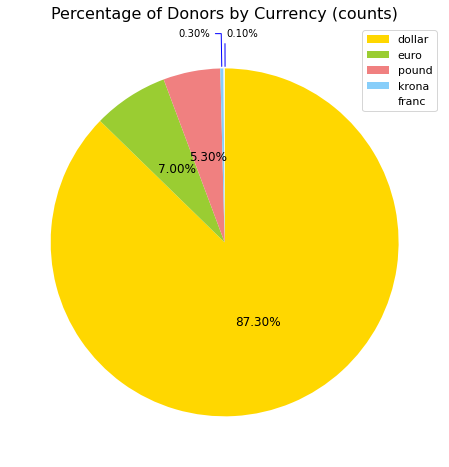

In [349]:
# Currency별 기부자 비율 파이차트 그리기!!

from matplotlib import font_manager, rc
from matplotlib import style
'''
한글 라벨링에 필요
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')
'''
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'white']
labels = currency_all['currency']
ratio = currency_all['percentage']
# explode = (0.0, 0.0, 0.0, 0.0, 0.0)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임생성

pie = ax.pie(ratio, colors=colors, startangle=90, counterclock=False) 
    #, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, textprops={'fontsize':13})

total = np.sum(ratio) ## 빈도수 합

threshold = 5 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
 
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
 
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-', color='b'),bbox=bbox_props,va='center') #퍼센트 선 속성변경
 
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{ratio[i]/total*100:.2f}')
        text = f'{ratio[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if ratio[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang2-0.5)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일 (A:각도 변경)
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(5*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=12)
    
plt.legend(pie[0],labels,loc='upper right', fontsize=11) ## 범례
plt.title('Percentage of Donors by Currency (counts)', fontsize=16)
plt.show()


### 2. 캠페인기준

In [219]:
# currency별 캠페인 비율
currency_counts_g = general['currency'].value_counts()
donation_counts_g = general['currency'].count()
currency_percentage_g = pd.DataFrame((round((currency_counts_g / donation_counts_g),3)*100))
currency_percentage_g = currency_percentage_g.reset_index()
currency_percentage_g.columns=['currency','percentage']
currency_percentage_g

,currency,percentage
0,dollar,91.2
1,euro,4.1
2,pound,3.8
3,krona,0.8
4,franc,0.1


In [221]:
#currency별 캠페인건 수
cu_counts_g = pd.DataFrame(currency_counts_g)
cu_counts_g = cu_counts_g.reset_index()
cu_counts_g.columns = ['currency','counts']
cu_counts_g

,currency,counts
0,dollar,3562
1,euro,160
2,pound,149
3,krona,30
4,franc,3


In [223]:
#currency별 기부자수, 기부자비율, 기부총액 합치기
currency_all_g = cu_counts_g.merge(currency_percentage_g, on='currency', how='left')
currency_all_g

,currency,counts,percentage
0,dollar,3562,91.2
1,euro,160,4.1
2,pound,149,3.8
3,krona,30,0.8
4,franc,3,0.1


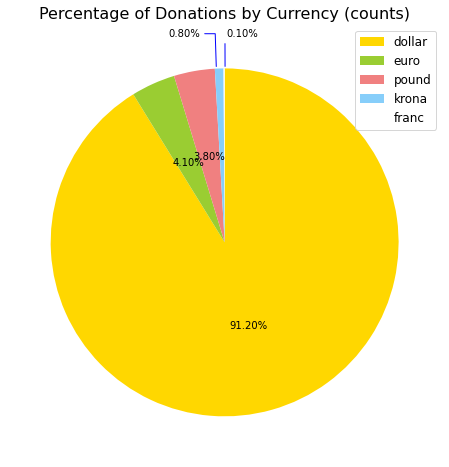

In [351]:
# currency별 캠페인 수 비율 차트 그리기!!

from matplotlib import font_manager, rc
from matplotlib import style
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'white']
labels = currency_all_g['currency']
ratio = currency_all_g['percentage']
# explode = (0.0, 0.0, 0.0, 0.0, 0.0)

fig = plt.figure(figsize=(8,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임생성

pie = ax.pie(ratio, colors=colors, startangle=90, counterclock=False) 
    #, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, textprops={'fontsize':13})

total = np.sum(ratio) ## 빈도수 합

threshold = 3 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
 
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
 
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-', color='b'),bbox=bbox_props,va='center') #퍼센트 선 속성변경
spacing = 0.1
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{ratio[i]/total*100:.2f}')
        text = f'{ratio[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if ratio[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang2-0.5)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일 (A:각도 변경)
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(3*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=10)
    
plt.legend(pie[0],labels,loc='upper right', fontsize=12) ## 범례
plt.title('Percentage of Donations by Currency (counts)', fontsize=16)
plt.show()

## 통화별 성공 건수 비교

In [356]:
# general과 donations 테이블 LEFT JOIN
donation_gen = donations.merge(general, on='chid', how='left')

In [357]:
donation_gen.columns

Index(['chid', 'donation_id', 'amount', 'is_anonymous', 'name', 'created_at',
       'profile_url', 'currency_x', 'amount_dollar', 'Unnamed: 0', 'url',
       'scrape_date', 'title', 'created_date', 'funds_raised', 'funds_target',
       'picture', 'org_picture', 'counts_status_code', 'velocity_status_code',
       'updates_status_code', 'comments_status_code', 'donations_status_code',
       'currency_y', 'tags', 'story', 'receiver_name', 'receiver_tax',
       'total_photos', 'total_co_photos', 'total_community_photos',
       'total_comments', 'total_updates', 'total_donations',
       'total_unique_donors', 'amount_raised_unattributed',
       'number_of_donations_unattributed', 'campaign_hearts',
       'social_share_total', 'num_recent_donations', 'recent_time_window',
       'funds_raised_dollar', 'funds_target_dollar',
       'amount_raised_unattributed_dollar', 'char_age', 'success',
       'dum_success'],
      dtype='object')

In [362]:
# 원하는 컬럼 추출
succ = donation_gen[['chid','donation_id','currency_x','amount','is_anonymous','name','success','dum_success']]
succ.head()

,chid,donation_id,currency_x,amount,is_anonymous,name,success,dum_success
0,1,0,dollar,480.0,False,Pedal For Peace Bike Ride T-shirt Sales,False,0
1,1,1,dollar,10.0,False,Jacquelin Pabon,False,0
2,1,2,dollar,50.0,False,Mindy Bemis,False,0
3,1,3,dollar,100.0,False,Dana Severs,False,0
4,1,4,dollar,100.0,False,Linsey Fraser,False,0


In [403]:
#currency별로 성공건수 구하기
cu_succ = succ.groupby(['currency_x', 'success']).size().unstack(fill_value=0)
cu_succ = cu_succ.reset_index()
cu_succ.columns = ['currency','Fail','Success']
cu_succ[['currency','Success']].sort_values(by='Success', ascending = False)

,currency,Success
0,dollar,493129
4,pound,21295
1,euro,17343
3,krona,1366
2,franc,77


### currency별 anonymous 기부 건수 & 금액의 차이 확인

In [211]:
# currency별 기명, 무기명 기부 건수 컬럼 만들기
an_count = currency.groupby(['currency', 'is_anonymous']).size().unstack(fill_value=0) # anonymous 0과 1을 컬럼으로 빼기
an_count = pd.DataFrame(an_count)
an_count = an_count.reset_index()
an_count.columns = ['currency','identified','anonymous']
count_percentage = an_count.assign(identified_percentage = 
                                             round(an_count['identified']/
                                                   (an_count['identified']+an_count['anonymous']),2)*100,
                                             anonymous_percentage = 
                                             round(an_count['anonymous']/
                                                   (an_count['anonymous']+an_count['identified']),2)*100)
count_percentage

,currency,identified,anonymous,identified_percentage,anonymous_percentage
0,dollar,1360295,552695,71.0,29.0
1,euro,94966,58347,62.0,38.0
2,franc,1235,1020,55.0,45.0
3,krona,4509,2558,64.0,36.0
4,pound,76061,39991,66.0,34.0


Text(0.5, 1.0, 'Percentage of Anonymous by Currency (counts)')

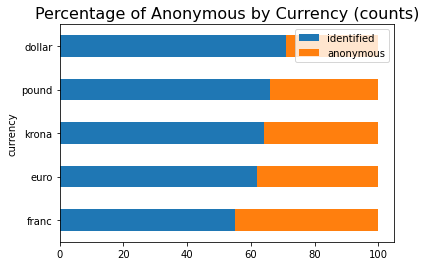

In [212]:
# currency별 기명, 무기명 기부 건수 비율 그래프 그리기 (버전1)
count_percentage.index=count_percentage['currency'] #currency를 index로 만들기
count_bar = count_percentage[['identified_percentage','anonymous_percentage']]
count_bar.reset_index()
count_bar.columns = ['identified','anonymous']
count_bar = count_bar.sort_values(by=['identified'])
count_bar.plot(kind='barh', stacked = True)
plt.title('Percentage of Anonymous by Currency (counts)', fontsize=16)

Text(0.5, 1.0, 'Percentage of Anonymous by Currency (counts)')

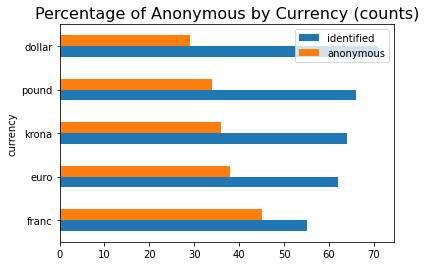

In [213]:
# currency별 기명, 무기명 기부 건수 비율 그래프 그리기 (버전2)
count_bar.plot(kind='barh')
plt.title('Percentage of Anonymous by Currency (counts)', fontsize=16)

In [214]:
# currency별 기명, 무기명 기부 금액 컬럼 만들기
an_amount = currency.groupby(['currency', 'is_anonymous']).agg({'amount':'sum'}).unstack(fill_value=0)
an_amount.reset_index()
an_amount.columns=['identified','anonymous']
amount_percentage = an_amount.assign(identified_percentage = 
                                             round(an_amount['identified']/
                                                   (an_amount['identified']+an_amount['anonymous']),2)*100,
                                             anonymous_percentage = 
                                             round(an_amount['anonymous']/
                                                   (an_amount['anonymous']+an_amount['identified']),2)*100)

amount_percentage

,identified,anonymous,identified_percentage,anonymous_percentage
currency,,,,
dollar,158858317.0,58152642.0,73.0,27.0
euro,7562900.0,3588071.0,68.0,32.0
franc,147877.0,91066.0,62.0,38.0
krona,2313506.0,1088474.0,68.0,32.0
pound,4000954.0,2337091.0,63.0,37.0


Text(0.5, 1.0, 'Percentage of Anonymous by Currency (amount)')

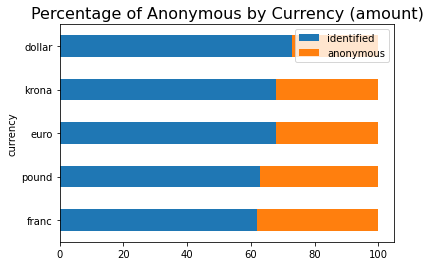

In [215]:
# currency별 기명, 무기명 기부 금액 비율 그래프 그리기 (버전1)
#amount_percentage.index=amount_percentage['currency'] #currency를 index로 만들기
amount_bar = amount_percentage[['identified_percentage','anonymous_percentage']]
amount_bar.reset_index()
amount_bar.columns = ['identified','anonymous']
amount_bar = amount_bar.sort_values(by=['identified'])
amount_bar.plot(kind='barh', stacked = True)
plt.title('Percentage of Anonymous by Currency (amount)', fontsize=16)

Text(0.5, 1.0, 'Percentage of Anonymous by Currency (amount)')

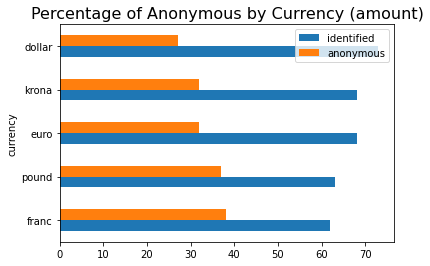

In [216]:
# currency별 기명, 무기명 기부 금액 비율 그래프 그리기 (버전2)
amount_bar.plot(kind='barh')
plt.title('Percentage of Anonymous by Currency (amount)', fontsize=16)

In [423]:
# currency별 기명, 무기명 기부 금액 범위 정하기 전 정보 알아보기 (describe)
amount_df = currency[['currency','amount']]
amount_desc = amount_df.describe()
amount_desc.loc['count'] = amount_desc.loc['count'].astype(int).astype(str)
amount_desc.iloc[1:] = amount_desc.iloc[1:].applymap('{:.1f}'.format)
print(amount_desc)
#amount_cu = currency.groupby(['currency']).size()
#amount_cu`

         amount
count   1048543
mean      105.4
std       890.0
min         1.0
25%        20.0
50%        50.0
75%       100.0
max    400000.0


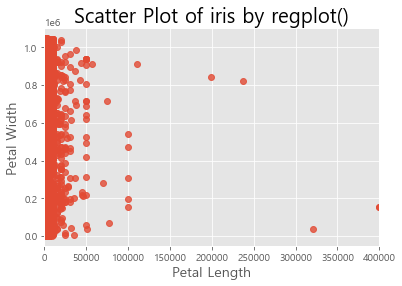

In [456]:
## currency별 기명, 무기명 기부 금액 범위 정하기 전 정보 알아보기 (scatter)
sns.regplot(x=currency['amount'], 

           y=currency['donation_id'], 

           fit_reg=False) # no regression line

plt.title('Scatter Plot of iris by regplot()', fontsize=20)

plt.xlabel('Petal Length', fontsize=14)

plt.ylabel('Petal Width', fontsize=14)
#plt.xlim([0,50000])
plt.show()

In [478]:
#currency별 금액대 기부건수 (index: currency)
amount_df['amount_cut']=pd.cut(amount_df.amount, bins=[0,10,20,30,40,50,60,70,80,90,100,400000], 
                               labels=['a','b','c','d','e','f','g','h','i','j','k']) # 금액대 나눠서 라벨링
amount_range_cu = amount_df.groupby(['currency','amount_cut']).size().unstack(fill_value=0) # 라벨링한 것 그룹별 합산
amount_range_cu.columns = ['1~10','11~20','21~30','31~40,','41~50','51~60','61~70','71~80','81~90','91~100','100~'] #컬럼명지정
amount_range_cu


<ipython-input-478-76f260512d4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amount_df['amount_cut']=pd.cut(amount_df.amount, bins=[0,10,20,30,40,50,60,70,80,90,100,400000],


,1~10,11~20,21~30,"31~40,",41~50,51~60,61~70,71~80,81~90,91~100,100~
currency,,,,,,,,,,,
dollar,90773,122024,126596,20823,194439,4801,1818,8568,1715,197619,122087
euro,23535,20010,8870,1538,16759,495,296,394,242,9220,6350
franc,485,246,87,16,107,20,7,2,0,86,110
krona,40,52,30,20,204,9,6,15,4,704,3110
pound,28421,14844,5694,1852,6303,265,114,278,129,3584,2727


In [479]:
#currency별 금액대 기부건수 (index: range)
amount_df['amount_cut']=pd.cut(amount_df.amount, bins=[0,10,20,30,40,50,60,70,80,90,100,400000], 
                               labels=['1~10','11~20','21~30','31~40,','41~50','51~60','61~70','71~80','81~90','91~100','100~']) # 금액대 나눠서 라벨링
amount_range_ra = amount_df.groupby(['amount_cut','currency']).size().unstack(fill_value=0) # 라벨링한 것 그룹별 합산
amount_range_ra


<ipython-input-479-1890cfc92989>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amount_df['amount_cut']=pd.cut(amount_df.amount, bins=[0,10,20,30,40,50,60,70,80,90,100,400000],


currency,dollar,euro,franc,krona,pound
amount_cut,,,,,
1~10,90773,23535,485,40,28421
11~20,122024,20010,246,52,14844
21~30,126596,8870,87,30,5694
"31~40,",20823,1538,16,20,1852
41~50,194439,16759,107,204,6303
51~60,4801,495,20,9,265
61~70,1818,296,7,6,114
71~80,8568,394,2,15,278
81~90,1715,242,0,4,129


Text(0.5, 1.0, 'Number of donation by dollar amount range (currency)')

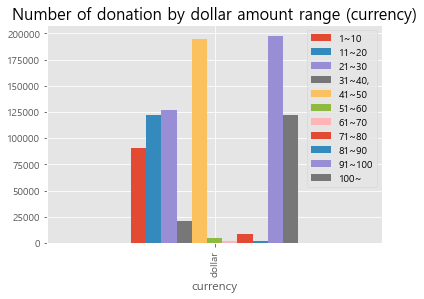

In [486]:
#dollar의 금액대 기부건수 그래프(index: currency)
dollar_range = amount_range_cu.loc[['dollar']]
dollar_range.plot(kind='bar')
plt.title('Number of donation by dollar amount range (currency)', fontsize=16)

Text(0.5, 1.0, 'Number of donation by dollar amount range (range)')

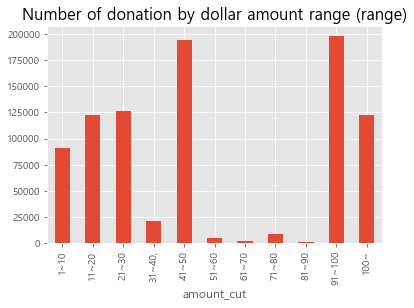

In [487]:
#dollar의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['dollar'].plot(kind='bar')
plt.title('Number of donation by dollar amount range (range)', fontsize=16)

Text(0.5, 1.0, 'Number of donation by euro amount range (range)')

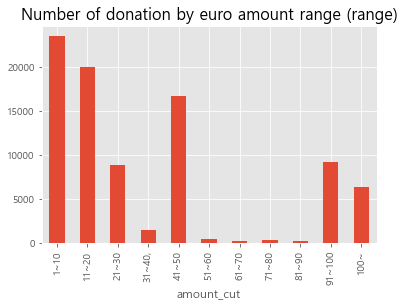

In [488]:
#euro의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['euro'].plot(kind='bar')
plt.title('Number of donation by euro amount range (range)', fontsize=16)

Text(0.5, 1.0, 'Number of donation by pound amount range (range)')

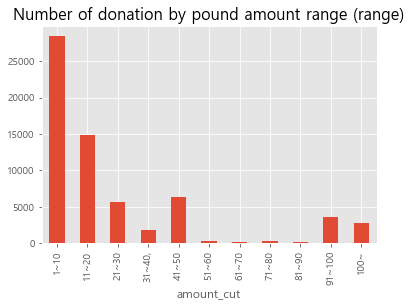

In [491]:
#pound의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['pound'].plot(kind='bar')
plt.title('Number of donation by pound amount range (range)', fontsize=16)

Text(0.5, 1.0, 'Number of donation by krona amount range (range)')

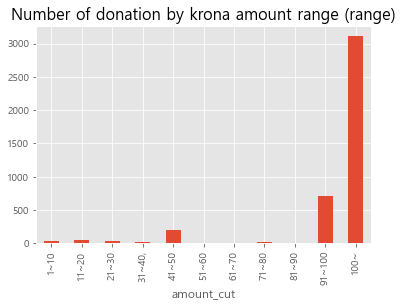

In [492]:
#krona의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['krona'].plot(kind='bar')
plt.title('Number of donation by krona amount range (range)', fontsize=16)

Text(0.5, 1.0, 'Number of donation by franc amount range (range)')

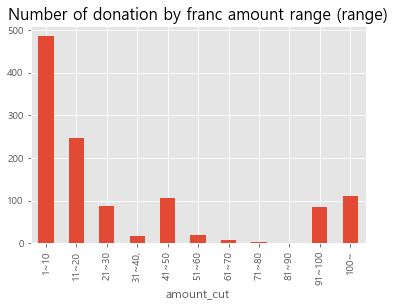

In [494]:
#franc의 금액대 기부건수 그래프(index: amount_cut)
amount_range_ra['franc'].plot(kind='bar')
plt.title('Number of donation by franc amount range (range)', fontsize=16)

In [56]:
donation_chid = donations['amount'].value_counts().sort_values(ascending=False)
donation_chid.head(20)

50.0      213729
100.0     210312
20.0      128126
25.0      104133
10.0       95527
5.0        42330
200.0      39018
30.0       33989
500.0      22500
15.0       21676
40.0       16982
250.0      16938
150.0      12598
1000.0     10874
300.0       9190
75.0        7121
35.0        3570
18.0        3282
60.0        2908
45.0        2904
Name: amount, dtype: int64

In [57]:
donation_amount_top20 = donation_chid.head(20)

In [58]:
top20_donation_amount = donation_amount_top20.index

In [60]:
for index, amount in enumerate(list(top20_donation_amount)):
    print ("TOP", index + 1, ":", amount)

TOP 1 : 50.0
TOP 2 : 100.0
TOP 3 : 20.0
TOP 4 : 25.0
TOP 5 : 10.0
TOP 6 : 5.0
TOP 7 : 200.0
TOP 8 : 30.0
TOP 9 : 500.0
TOP 10 : 15.0
TOP 11 : 40.0
TOP 12 : 250.0
TOP 13 : 150.0
TOP 14 : 1000.0
TOP 15 : 300.0
TOP 16 : 75.0
TOP 17 : 35.0
TOP 18 : 18.0
TOP 19 : 60.0
TOP 20 : 45.0


In [49]:
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

In [54]:
donation_chid.iplot(kind='line', theme='white')